In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

### Visualize Data

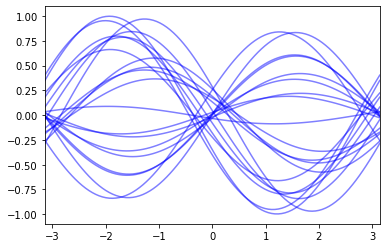

In [2]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)
#2000 different sine functions
#each function have 100 points

# Visualize data samples
for i in range(20):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Build Neural Process

In [3]:
from neural_process import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

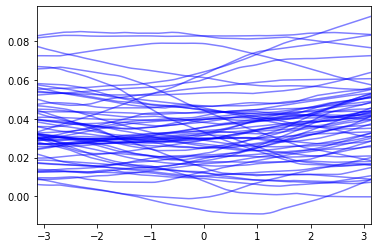

In [4]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

In [5]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 2
num_context = 99
num_target = 1

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

# for name, param in neuralprocess.named_parameters():
#     # if param.requires_grad:
#         print(name, param.data)
#         print(param.data.size())
# layerCount = 0
# ct = 0
# for child in neuralprocess.children():
#     print('layer ',layerCount)
#     ct = 0
#     for param in child.parameters():
#         print(ct,'th in laryer',layerCount)
#         ct += 1
#         print(param.data)
#         print(param.data.size())
#     layerCount += 1

iteration 200, loss 43.751
iteration 400, loss 27.326
iteration 600, loss 53.357
iteration 800, loss 83.632
iteration 1000, loss 45.482
Epoch: 0, Avg_loss: 47.109202105224135
iteration 1200, loss 17.145
iteration 1400, loss 88.105
iteration 1600, loss 61.825
iteration 1800, loss 74.469
iteration 2000, loss 58.845
Epoch: 1, Avg_loss: 22.930835633358917
iteration 2200, loss 2.503
iteration 2400, loss -35.052
iteration 2600, loss -19.104
iteration 2800, loss 15.344
iteration 3000, loss -22.026
Epoch: 2, Avg_loss: -12.739643363520504
iteration 3200, loss -115.003
iteration 3400, loss -115.808
iteration 3600, loss -101.798
iteration 3800, loss -27.534
iteration 4000, loss -95.158
Epoch: 3, Avg_loss: -75.21244474846125
iteration 4200, loss -111.455
iteration 4400, loss -79.024
iteration 4600, loss -90.029
iteration 4800, loss -118.819
iteration 5000, loss -15.476
Epoch: 4, Avg_loss: -97.09888036893308
iteration 5200, loss -131.375
iteration 5400, loss -126.536
iteration 5600, loss -119.293
i

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

In [6]:
# x_target = torch.Tensor(np.linspace(-pi, pi, 100))
# x_target = x_target.unsqueeze(1).unsqueeze(0)
# 
# for i in range(2):
#     z_sample = torch.randn((1, z_dim))
#     mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
#     plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
#              c='b', alpha=0.5)
#     plt.xlim(-pi, pi)

### Visualize samples from posterior

torch.Size([1, 99, 1])


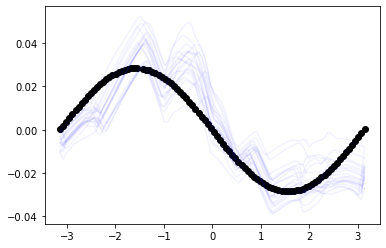

In [7]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
# x,y here just the first sample in the dataset
# the final result will show that it will be very close to the sample in the dataset
# since we use this sample as context(observed data)
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)
print(x_context.size())
# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(20):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')
